In [1]:
from PIL import Image
import numpy as np
import seaborn as sns
import sys
import math
import time
import multiprocessing as mp


In [2]:
%autosave 20

Autosaving every 20 seconds


In [3]:
img = Image.open('lena2.jpg')

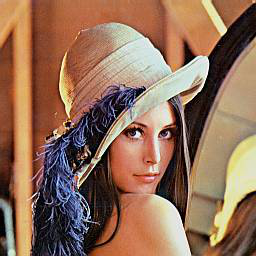

In [4]:
img

In [5]:
imgpb = img.convert('L')

In [6]:
img_array = np.asarray(imgpb)

# definicao das funcoes

### funcoes rotacao

In [7]:
def rotacaoMapeamentoReverso(img_array, angulo = 0):
    
    angulo = math.radians(angulo) #angulo de rotacao
    largura = len(img_array[0])# largura da imagem
    altura = len(img_array)#altura da imagem
    diagonal = math.ceil(math.sqrt(largura ** 2 + altura ** 2))  #baskara para medir diagonal
    
    
    # Centro da imagem
    centro_X = int(largura / 2) #centro do eixo x
    centro_y = int(altura / 2) #centro do eixo y
    centro_diagonal = diagonal / 2 # Centro da diagonal(imagem de destino)
    
    img_array_manipulavel = np.zeros((diagonal, diagonal)) #criando imagem destino vazia
    
    pi = math.pi  #definindo valor de pi
    
    for i in range(diagonal):  
        for j in range(diagonal):
            
            # Converter os indices para coordenadas cartesianas
            x = j - centro_diagonal
            y = centro_diagonal - i
            # Converter cartesiano para polar
            distancia = math.sqrt(x ** 2 + y ** 2) # raio
            polarAngulo = 0
            if x == 0: #ŕimeira posicao do x
                if y == 0: # primeira posicao do y é Centro da imagem, não precisa rotacionar
                    img_array_manipulavel[i][j] = img_array[centro_y][centro_X] #copia o valor na posicao+
                    continue
                elif y < 0:  #y negativo
                    polarAngulo = 1.5 * pi
                else:
                    polarAngulo = 0.5 * pi #y positivo
            else:
                polarAngulo = math.atan2(y, x)  #restante da imagem , angulo polar = atang² de y sob x
            # Rotação reversa
            polarAngulo -= angulo
            # Converter polar para cartesiano
            trueX = distancia * math.cos(polarAngulo)
            trueY = distancia * math.sin(polarAngulo)
            trueX = trueX + centro_X
            trueY = centro_y - trueY
            # Cartesiano para os indices da matriz
            floorX = int(trueX // 1)  # // pega a parte inteira da divisao
            floorY = int(trueY // 1)  
            ceilX = int(math.ceil(trueX))  #ceil retorna o teto nao menor que o valor, ex 300.26 retorna 301.0
            ceilY = int(math.ceil(trueY))
            # Verificação de limites 
            if floorX < 0 or ceilX < 0 or floorX >= largura or ceilX >= largura or floorY < 0 or ceilY < 0 or floorY >= altura or ceilY >= altura:
                continue
            deltaX = trueX - floorX
            deltaY = trueY - floorY
            # Vizinhança
            topLeft = img_array[floorY][floorX]
            topRight = img_array[floorY][ceilX]
            bottomLeft = img_array[ceilY][floorX]
            bottomRight = img_array[ceilY][ceilX]
            # Interpolação linear pela horizontal superior
            topColor = (1 - deltaX) * topLeft + deltaX * topRight
            # Interpolação linear pela horizontal inferior
            bottomColor = (1 - deltaX) * bottomLeft + deltaX * bottomRight
            # Interpolação linear pela vertical
            color = round((1 - deltaY) * topColor + deltaY * bottomColor)
            # Checagem de limites da cor
            if color < 0:
                color = 0
            elif color > 255:
                color = 255
            img_array_manipulavel[i][j] = color
    return Image.fromarray(np.uint8(img_array_manipulavel))

In [8]:
# Rotação por mapeamento direto, IC = JC = 0
def rotacaoMapeamentoDireto(img_array, theta = 0):
    map = np.zeros((len(img_array), len(img_array[0]), 2), dtype = int) # array contendo as posições mapeadas
    cos_theta = math.cos(math.radians(theta)) # cosseno angulo
    sin_theta = math.sin(math.radians(theta)) #seno angulo
    
    limite_superior = limite_esquerdo = limite_direito = limite_inferior = 0
    for i in range(0, len(img_array)):
        for j in range(0, len(img_array[0])):
                map_i = round((i * cos_theta) - (j * sin_theta))
                map_j = round((i * sin_theta) + (j  * cos_theta))
                
                if map_i < limite_superior:
                    limite_superior = map_i
                elif map_i > limite_inferior:
                    limite_inferior = map_i
                if map_j < limite_esquerdo:
                    limite_esquerdo = map_j
                elif map_j > limite_direito:
                    limite_direito = map_j

                map[i][j][0] = map_i
                map[i][j][1] = map_j
                
    r = abs(limite_inferior - limite_superior)
    c = abs(limite_direito - limite_esquerdo)
    print("r: " + str(r) + " c: " + str(c))

    dummy_img_array = np.zeros((r + 1, c + 1, 3), dtype = int)
    for i in range(len(img_array)):
        for j in range(len(img_array[0])):
            dummy_img_array[map[i][j][0] + abs(limite_superior)][map[i][j][1] + abs(limite_esquerdo)] = img_array[i][j].copy()
    
    return Image.fromarray(np.uint8(dummy_img_array), mode = "RGB") # retorna a imagem transformada

### Função para encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais.
### O parâmetro n é um inteiro no intervalo [0, RxC-1].

In [9]:

def aproximacaoImagem(img_array, n = 0):
    if(n >= (len(img_array) * len(img_array[0])) or n < 0):
        return None # n fora do intervalo permitido!
    
    dct_array = DCT2D(img_array)
    list_coeff = []
    dc = dct_array[0][0] # obtem dc
    if n > 0: # mais de um coeficiente a ser mantido
        for i in range(len(dct_array)):
            for j in range(len(dct_array[0])):
                if(i != 0 or j != 0): # Nao adicionar dc a lista de coeficientes
                    list_coeff.append({"abs(Value)": abs(dct_array[i][j]), "Value": dct_array[i][j], "i": i, "j": j})
        # Ordenar a lista de coeficientes pelo valor absoluto e pegar os n maiores coeficientes
        list_coeff_sorted = sorted(list_coeff, key = lambda x : x['abs(Value)'], reverse = True)
        top_coeffs = list_coeff_sorted[ : n]
        dct_array.fill(0) # zerar o array
        for coeff in top_coeffs: # recolocar os maiores coeficientes no array
            dct_array[coeff['i']][coeff['j']] = coeff['Value']
    else: # manter apenas DC, zerar o resto
        dct_array.fill(0) # zerar o array
        
    dct_array[0][0] = dc
        
    dummy_img_array = DCT2D(dct_array, inverse = True) # voltar pro dominio do espaco
    
    # garantir que os limites sejam preservados
    for i in range(len(dummy_img_array)):
        for j in range(len(dummy_img_array[0])):
            dummy_img_array[i][j] = round(dummy_img_array[i][j])
            if dummy_img_array[i][j] < 0:
                dummy_img_array[i][j] = 0
            elif dummy_img_array[i][j] > 255:
                dummy_img_array[i][j] = 255
                
    return Image.fromarray(np.uint8(dummy_img_array))


### Função para encontrar a imagem resultante da filtragem de I por um filtro passa-baixas ideal quadrado,
### com frequência de corte fc (parâmetro especificado pelo usuário) igual à aresta do quadrado, em pixels.

In [10]:

def passaBaixas(img_array, fc = 4):
    if fc > len(img_array) and fc > len(img_array[0]):
        return None # fc maior que o tamanho da imagem em R e C

    dct_array = DCT2D(img_array) # converter a imagem pro dominio da frequencia
    # Realizar o corte
    if fc < len(img_array[0]):
        dct_array[ : , fc + 1 : ] = 0 # zerar tudo em cada coluna que esteja de fc + 1 a c - 1
    if fc < len(img_array):
        dct_array[fc + 1 : , : ] = 0 # zerar tudo em cada linha que esteja de fc + 1 a r - 1
    
    dummy_img_array = DCT2D(dct_array, inverse = True) # voltar pro dominio do espaco
        
    # garantir que os valores fiquem nos limites
    for i in range(len(dummy_img_array)):
        for j in range(len(dummy_img_array[0])):
            dummy_img_array[i][j] = round(dummy_img_array[i][j])
            if dummy_img_array[i][j] < 0:
                dummy_img_array[i][j] = 0
            elif dummy_img_array[i][j] > 255:
                dummy_img_array[i][j] = 255
                
    return Image.fromarray(np.uint8(dummy_img_array))

### FUNCOES DCT IDCT

## Função para exibir o módulo da DCT de I, sem o nível DC, e o valor do nível DC


In [11]:
def moduloDCT(img_array):
    dct_array = DCT2D(img_array)
    
    dc = dct_array[0][0]
    dct_array[0][0] = 0

    # Exibir o modulo da dct como mapa de calor
    #heatMap = sns.heatmap(abs(dct_array))
    
    result = Image.fromarray((np.clip(dct_array, 0, 255)).astype(np.uint8))
    
    return dc, result


###   DCT sobre um vetor de 1 dimensão


In [12]:
def DCT1D(x):
    N = len(x) # tamanho do vetor
    X = np.zeros(N) # criar um vetor de tamanho N
    
    # variaveis auxiliares de aceleracao
    c0 = math.sqrt(0.5) # valor de ck para k = 0
    coef2 = math.sqrt(2 / N) # valor do outro coeficiente externo ao somatorio
    pi = math.pi # valor de pi
    
    for k in range(N):
        sum = 0 # variavel do resultado do somatorio
        # termos do cosseno
        term1 = (pi * k) / N # primeiro termo, a ser multiplicado por n
        term2 = (k * pi) / (N << 1) # segundo termo do valor do cosseno, constante dentro do somatorio, (N << 1) equivale a (N * 2)
        for n in range(N): # laco do somatorio
            sum += x[n] * math.cos(term1 * n + term2)
        
        if k == 0: # multiplicar por c0 caso k seja 0, caso contrario, fazer nada uma vez que ck = 1 p/ k != 0
            sum *= c0
        
        sum *= coef2 # multiplicar pelo outro coeficiente
        X[k] = sum # atribuir a X[k] resultado do somatorio
        
    return X

### Função que realiza a DCT inversa sobre um vetor de 1 dimensão


In [13]:
def IDCT1D(X):
    N = len(X) # tamanho do vetor
    x = np.zeros(N) # aloca o vetor
    
    # variaveis auxiliares
    c0 = math.sqrt(0.5) # valor de ck para k = 0
    coef2 = math.sqrt(2 / N) # valor do outro coeficiente externo ao somatorio
    pi = math.pi # valor de pi
    
    for n in range(N):
        sum = 0
        # termos do cosseno
        term1 = (pi * n) / N
        term2 = pi / (N << 1)
        for k in range(N):
            if X[k] != 0: # economia de operacoes
                if k == 0:
                    sum += (c0 * X[k] * math.cos(term1 * k + term2 * k))
                else:
                    sum += X[k] * math.cos(term1 * k + term2 * k)
                    
        sum *= coef2
        x[n] = sum
        
    return x

### Função que realiza a DCT (ou a inversa) sobre um vetor de duas dimensões (nesse caso, a imagem)


In [14]:
def DCT2D(img_array, inverse = False):
    # Pool de threads, paralelizar a exeução utilizando o número de cpus da máquina
    pool = mp.Pool(mp.cpu_count())
    
    # Aplicar DCT linha a linha
    if inverse is False:
        dct_img_array = pool.map(DCT1D, img_array)
    else: # DCT Inversa
        dct_img_array = pool.map(IDCT1D, img_array)
            
    # fazer a matriz transposta da imagem, assim permitindo que as colunas virem linhas e possam ser usadas em DCT1D
    dct_img_array = np.array(dct_img_array).T.tolist()
    
    # Aplicar DCT coluna a coluna
    if inverse is False:
        dct_img_array = pool.map(DCT1D, dct_img_array)
    else: # DCT Inversa
        dct_img_array = pool.map(IDCT1D, dct_img_array)
        
    # retornar ao formato R x C original
    dct_img_array = np.array(dct_img_array).T
    
    return dct_img_array # retornar a matriz transformada


# APLICACAO E TESTES

## ROTAÇÃO

## Map direto  (theta =  90, -90, 180 e 360, 47 e 194)

In [16]:
theta = 90

In [17]:
%time
img2_1 = rotacaoMapeamentoDireto(img_array, theta)

img2_2 = rotacaoMapeamentoDireto(img_array, -90)

img2_3 = rotacaoMapeamentoDireto(img_array, 180)

img2_4 = rotacaoMapeamentoDireto(img_array, 360)

img2_5 = rotacaoMapeamentoDireto(img_array, 47)

img2_6 = rotacaoMapeamentoDireto(img_array, 194)


print('doing....')



CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.5 µs
r: 255 c: 255
r: 255 c: 255
r: 255 c: 255
r: 255 c: 255
r: 360 c: 360
r: 309 c: 309
doing....


In [18]:
img2_1.save('rotacaoDIRETO_90.jpg')
img2_2.save('rotacaoDIRETO_-90.jpg')
img2_3.save('rotacaoDIRETO_180.jpg')
img2_4.save('rotacaoDIRETO_360.jpg')
img2_5.save('rotacaoDIRETO_47.jpg')
img2_6.save('rotacaoDIRETO_194.jpg')



print('Done....')

Done....


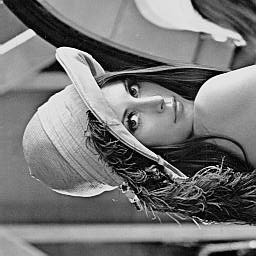

In [19]:
img2_1

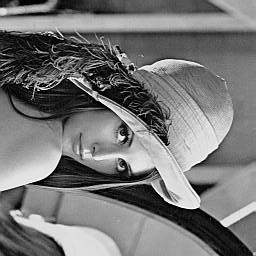

In [20]:
img2_2

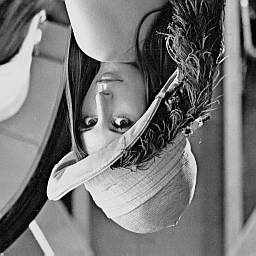

In [21]:
img2_3

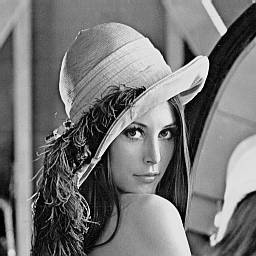

In [22]:
img2_4

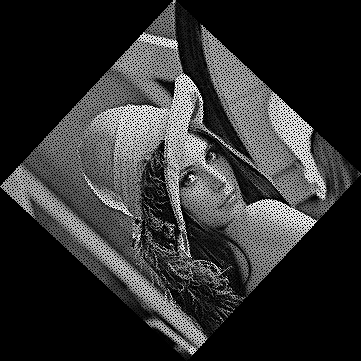

In [17]:
img2_5

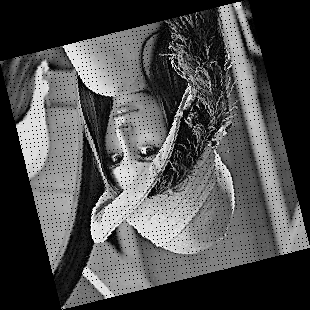

In [18]:
img2_6

### rot map reverso (theta =  90, -90, 180  360, 57 e -166 )

In [23]:
img3_1 = rotacaoMapeamentoReverso(img_array, theta)
img3_2 = rotacaoMapeamentoReverso(img_array, -90)
img3_3 = rotacaoMapeamentoReverso(img_array, 180)
img3_4 = rotacaoMapeamentoReverso(img_array, 360)


In [19]:
img3_5 = rotacaoMapeamentoReverso(img_array, 57)
img3_6 = rotacaoMapeamentoReverso(img_array, -166)


In [24]:
img3_1.save('rotacaoREVERSO_90.jpg')
img3_2.save('rotacaoREVERSO_-90.jpg')
img3_3.save('rotacaoREVERSO_180.jpg')
img3_4.save('rotacaoREVERSO_360.jpg')


In [20]:
img3_5.save('rotacaoREVERSO_57.jpg')
img3_6.save('rotacaoREVERSO_-166.jpg')






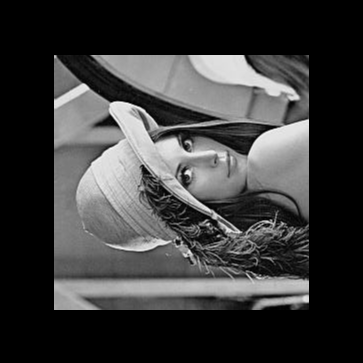

In [25]:
img3_1

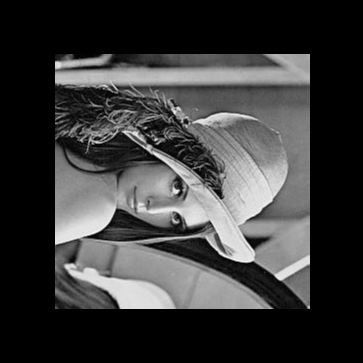

In [26]:
img3_2

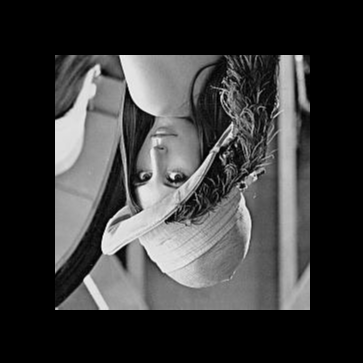

In [27]:
img3_3

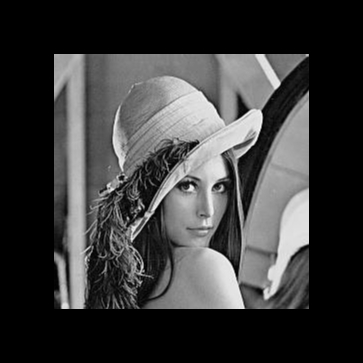

In [28]:
img3_4

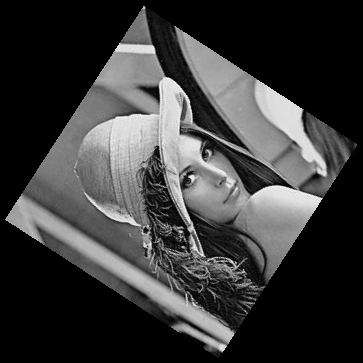

In [21]:
img3_5

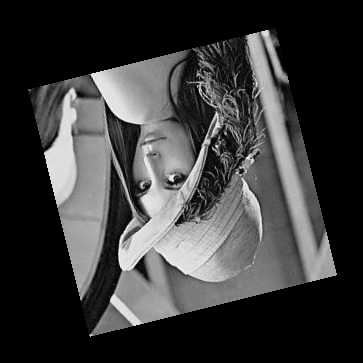

In [22]:
img3_6

# DCT

# aplicando para exibir o módulo da DCT de I, sem o nível DC, e o valor do nível DC


In [65]:
%time
dc, img4 = moduloDCT(img_array) # imagem monocromatica
print('saving....')
print('Done....\n')
print("Nível DC:", dc)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 12.9 µs
saving....
Done....

Nível DC: 30278.476562500004


In [66]:
img4.save('dct.jpg')

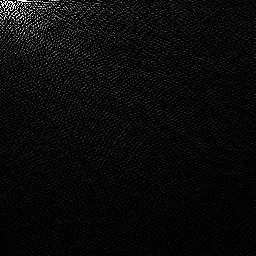

In [67]:
img4

# aplicando a idct na transformada pela dct (alterada)

In [61]:

    dct_array2 = DCT2D(img_array)
    
    dc = dct_array2[0][0]
    dct_array2[0][0] = 0
    
    dct_array2 = DCT2D(dct_array2, inverse = True)
    
    result = Image.fromarray((np.clip(dct_array2, 0, 255)).astype(np.uint8))
    
    print ("done")
    print ("valor dc" , dc) 
    
    


done
valor dc 30278.476562500004


In [57]:
result.save('dct-Idct.jpg')

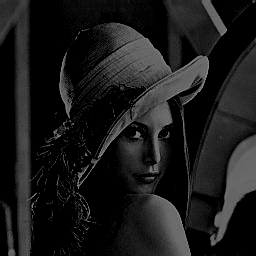

In [58]:
result

## aproximacao usando n coeficientes + dc  (testes para n_coef =  20, 50,  200, 1 e 2)

In [40]:
n_coef = 20 #número de coeficientes mais importantes 

In [42]:
%time

img5 = aproximacaoImagem(img_array, n = n_coef) # imagem monocromatica

img5_1 = aproximacaoImagem(img_array, n = 50) # imagem monocromatica

img5_2 = aproximacaoImagem(img_array, n = 200) # imagem monocromatica


print('saving....')
img5.save('n_coef_dct_20.jpg')
img5_1.save('n_coef_dct_50.jpg')
img5_2.save('n_coef_dct_200.jpg')

print('Done....')

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 23.4 µs
saving....
Done....


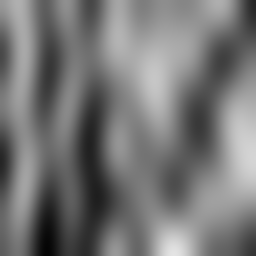

In [45]:
img5

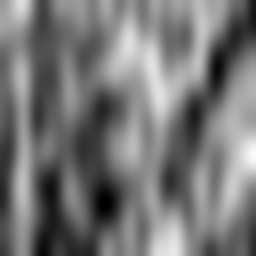

In [46]:
img5_1

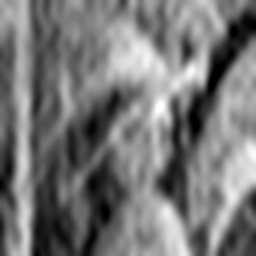

In [47]:
img5_2

In [15]:
%time

img5_3 = aproximacaoImagem(img_array, n = 1) # imagem monocromatica

img5_4 = aproximacaoImagem(img_array, n = 2) # imagem monocromatica




print('saving....')
img5_3.save('n_coef_dct_1.jpg')
img5_4.save('n_coef_dct_2.jpg')


print('Done....')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
saving....
Done....


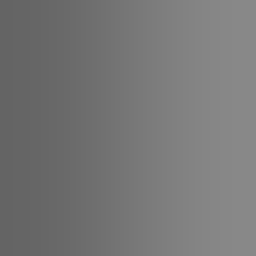

In [16]:
img5_3

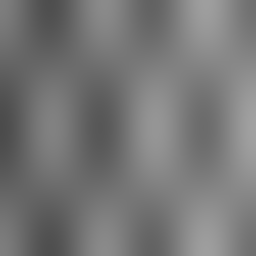

In [17]:
img5_4

# filtro passa baixas, (exemplos para fc = 45 e fc = 200)

In [48]:
fc  = 45  #frequência de corte (fc)

In [49]:
%time

img6= passaBaixas(img_array, fc = fc)
img6_1= passaBaixas(img_array, fc = 200)

print('saving....')
img6.save('passabaixa_45.jpg')
img6_1.save('passabaixa_200.jpg')

print('Done....')


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs
saving....
Done....


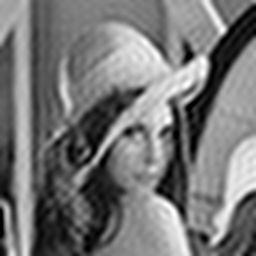

In [50]:
img6

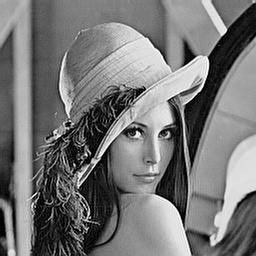

In [51]:
img6_1